<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Note: This notebook is a work in progress & will be updated continuously over the next week or so before it's ready - 24 May 2021

# Time series forecasting in TensorFlow

The goal of this notebook is to get you familiar with working with time series data.

It won't cover all of the time series field but by the end you will get a fairly good overview of things to consider for time series problems...

Outline:
* Get data (a time series)
* Format data
  * Turn data into a windowed dataset
  * Training/test sets for time series
  * Univariate - Bitcoin's price history
  * Multivariate - Bitcoin's price history + block size
* Model data
  * Baseline - naive forecasting
  * Baseline 2 - random forest regressor
  * Deep model - fully connected
  * Sequence models
    * LSTM
    * Conv1D
  * N-Beats algorithm - https://arxiv.org/pdf/1905.10437.pdf
* Evaluating a time series model
  * MAE
  * MSE
  * RMSE etc...
* Uncertainty estimates
  * Coconut uncertainty - epistemic uncertainty
  * Subway uncertainty - aleatory uncertainty
* Why forecasting is BS (turkey problem) - https://youtu.be/hRwimmE2wEk
  * Open system: beware (like fortune telling), see Mark Saroufim's tweet - https://twitter.com/marksaroufim/status/1366871736604532739?s=20 
  * Closed system: try it out 
* Exercises
* Extra-curriculum
  * Time series book - https://otexts.com/fpp2/accuracy.html 


## TODO: What is a time series problem?

* Forecasting
* Classification

## TODO: Get data

Let's predict the price of Bitcoin! Data source: https://www.coindesk.com/price/bitcoin

> **Note:** This is not financial advice, as you'll see time series forecasting for stock market prices is actually quite terrible.

See this tweet for reference: https://twitter.com/marksaroufim/status/1366871736604532739?s=20

TODO (upload to Google Storage/GitHub): Data: https://www.dropbox.com/s/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv?dl=0

In [1]:
!wget https://www.dropbox.com/s/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2021-05-24 04:32:19--  https://www.dropbox.com/s/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv [following]
--2021-05-24 04:32:19--  https://www.dropbox.com/s/raw/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce59df68e946ce950d6d1a9b988.dl.dropboxusercontent.com/cd/0/inline/BPFechDoLFa9uLO7s3kv-2y-XylB5aTAjVGuXnylTLOToTRmuY-wmLIlabvPNpweVrPmIFHK9XgAZ5ZEnOXtKY28IKjnaTVs7LVNeGofWN7m_ex6vpqzXHNT_izzofqriyAtc57T8AmhOVFoK3VMOt2j/file# [following]
--2021-05-24 04:32:19--  https://uce59df68e946ce950d6d1a9b988.dl.dropboxusercontent.com/cd/0/inline/

In [2]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.654990,124.304660,124.751660,122.563490
2013-10-02,BTC,125.455000,123.654990,125.758500,123.633830
2013-10-03,BTC,108.584830,125.455000,125.665660,83.328330
2013-10-04,BTC,118.674660,108.584830,118.675000,107.058160
2013-10-05,BTC,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
# TODO: time series often may not have very many samples (e.g. monthly = only 12 per year, daily = 365 per year... etc)
# Deep learning algorithms usually flourish with lots of data (1000's of samples)
len(df)

2787

In [5]:
# Only want closing price
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [6]:
bitcoin_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2787 non-null   float64
dtypes: float64(1)
memory usage: 43.5 KB


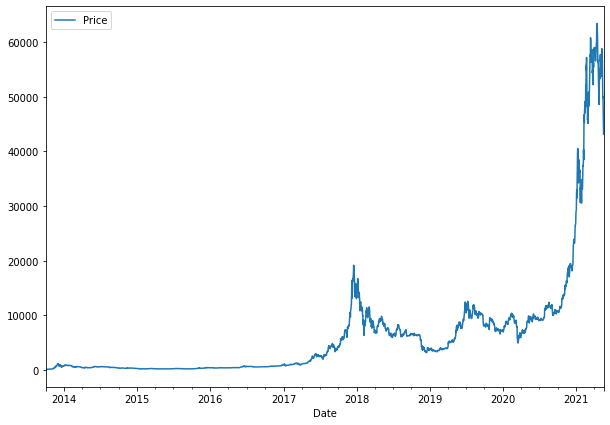

In [7]:
bitcoin_prices.plot(figsize=(10, 7));

In [8]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [9]:
# Windowing data
bitcoin_prices["Shift+1"] = bitcoin_prices["Price"].shift(1)
bitcoin_prices.head()

,Price,Shift+1
Date,,
2013-10-01,123.65499,NaN
2013-10-02,125.45500,123.65499
2013-10-03,108.58483,125.45500
2013-10-04,118.67466,108.58483
2013-10-05,121.33866,118.67466


### Importing time series as a CSV

In [10]:
# Importing with Python CSV - https://realpython.com/python-csv/
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

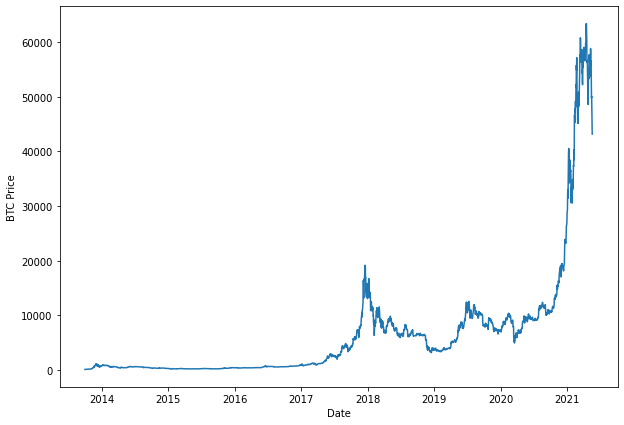

In [11]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, np.array(btc_price))
plt.xlabel("Date")
plt.ylabel("BTC Price");

## TODO: Format data 

* Turn data into a windowed dataset
* Training/test sets for time series
* Univariate - Bitcoin's price history
* Multivariate - Bitcoin's price history + block size

### TODO: Create train & test sets for time series

* Note: cannot do random split, time series will buckle under this (using future values in the past)
* Need to make train set: values from past, test set: values from "future"

In [12]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [13]:
# Wrong way to make train/test sets for time series
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((2229,), (558,), (2229,), (558,))

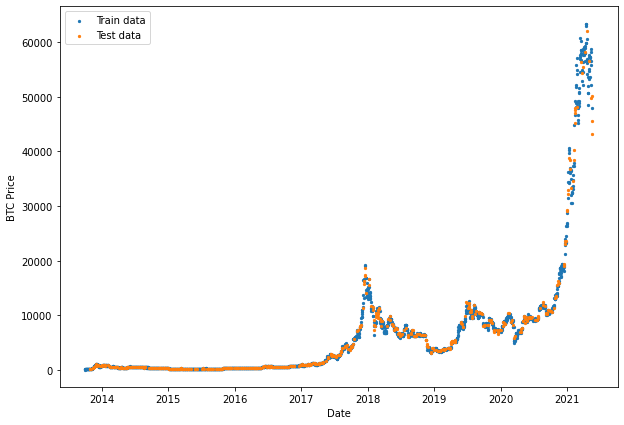

In [14]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend()
plt.show();

* TODO: Note: time series forecasting can often have many less data points than traditional deep learning projects (e.g. the entire history of BTC daily price data = only ~3000 samples)

* TODO: What kind of steps should we predict? E.g. 80/20 split is that realisitic? You may want to use all of the data up until the last week...

In [15]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

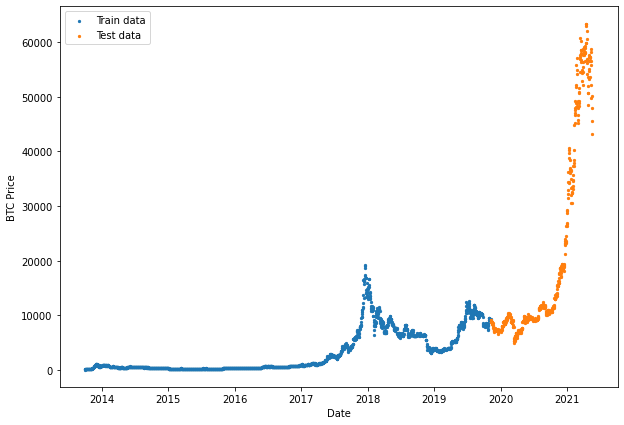

In [16]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend()
plt.show();

## TODO: Model data

* Baseline - naive forecasting
* Baseline 2 - moving average
* Deep model - fully connected
  * Fully connected with different size window/horizon
* Sequence models
  * LSTM
  * Conv1D
* N-Beats algorithm - https://arxiv.org/pdf/1905.10437.pdf

### Model 0: Naive forecast

Naive forecast = Use the previous timestep to predict the next timestep

$$\hat{y}_{t} = y_{t-1}$$ 

In [17]:
naive_forecast = y_test[:-1]
naive_forecast[:10]

array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
       8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
       8500.64355816, 8469.2608989 ])

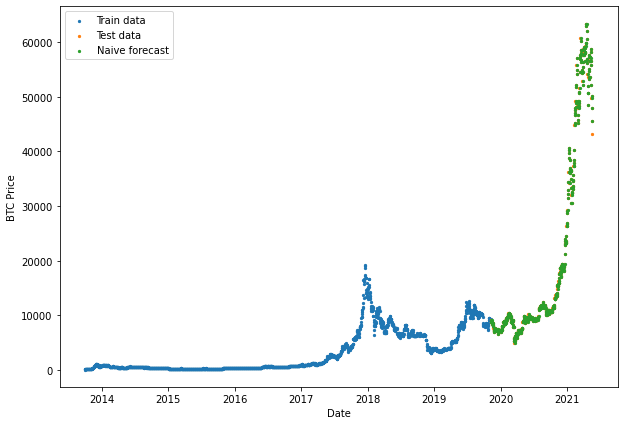

In [18]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.scatter(X_test[1:], naive_forecast, s=5, label="Naive forecast")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend()
plt.show();

TODO: Replace the function below with the improved plot function for time series

In [19]:
def plot_zoomed_in(new_preds=None, new_preds_name="New Preds", zoom_timesteps=100, plot_naive=True):
  # Plot naive forecast zoomed in
  plt.figure(figsize=(10, 7))
  plt.plot(X_test[-zoom_timesteps:], y_test[-zoom_timesteps:], label="Test data")
  if plot_naive:
    plt.plot(X_test[1:][-zoom_timesteps:], naive_forecast[-zoom_timesteps:], label="Naive forecast")
  if new_preds != None:
    plt.plot(X_test[-zoom_timesteps:], new_preds[-zoom_timesteps:], label=new_preds_name)
  plt.xlabel("Date")
  plt.ylabel("BTC Price")
  plt.legend()
  plt.show();

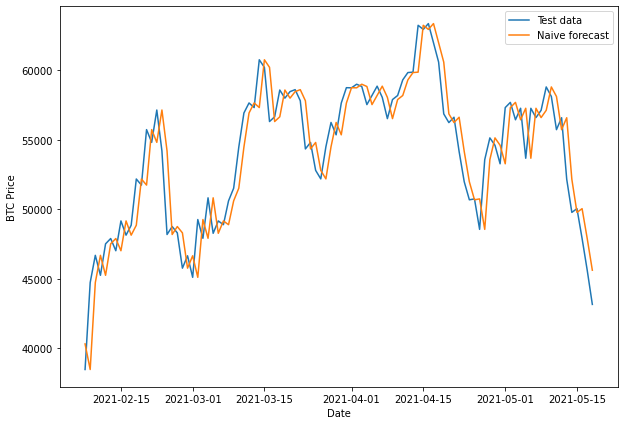

In [20]:
plot_zoomed_in()

## TODO: Evaluating a time series model

TK - this can be a function for each model (compares predictions to ground truth...)

TK - metrics for evaluating time series models: https://otexts.com/fpp2/accuracy.html

In [21]:
import tensorflow as tf

In [22]:
def scaled_mape(y_true, y_pred):
  return tf.reduce_mean(200 * (tf.abs(y_true - y_pred)/(tf.abs(y_true) + tf.abs(y_pred))))

In [23]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  smape = scaled_mape(y_true, y_pred)
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "mape": mape.numpy(),
          "smape": smape.numpy()}

In [24]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802, 'mape': 2.516525, 'mse': 1147547.0, 'smape': 2.5180573}

## TODO: Model 1: Moving average

TK - moving average can be our second baseline agaisnt the rest of the data..., this will still probably be another hard model to beat

## Windowing dataset

Why do we window?

TODO: We can turn our time series data into a **supervised learning problem**: use windows of the past to predict the future.

In [25]:
X_train, y_train

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', ...,
        '2019-11-05T00:00:00.000000000', '2019-11-06T00:00:00.000000000',
        '2019-11-07T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([ 123.65499   ,  125.455     ,  108.58483   , ..., 9369.62808116,
        9326.59962378, 9335.75240233]))

In [26]:
X_test[:10], y_test[:10]

(array(['2019-11-08T00:00:00.000000000', '2019-11-09T00:00:00.000000000',
        '2019-11-10T00:00:00.000000000', '2019-11-11T00:00:00.000000000',
        '2019-11-12T00:00:00.000000000', '2019-11-13T00:00:00.000000000',
        '2019-11-14T00:00:00.000000000', '2019-11-15T00:00:00.000000000',
        '2019-11-16T00:00:00.000000000', '2019-11-17T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]))

Want:

```
# Window for a week (univariate time series)
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [27]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 10 # use 10 timesteps to predict the horizon

In [28]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  [1, 2, 3, 4, 5, 6] -> ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [29]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=10, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # print(len(x)-1)
  start = len(x) % window_size # account for data which doesn't fit into window, cut off at start
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0) # create 2D array of window_size
  # print(f"Window step:\n {window_step[-5:]}")
  window_indexes = start + window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon+start-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:2], window_indexes[-2:]}")
  windowed_array = x[window_indexes] # get the original array indexed with windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [30]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2770, 2770)

### TODO: Make train/test splits after windowing, this helps with evaluation...

In [31]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [32]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2216, 554, 2216, 554)

In [33]:
train_windows[:5], train_labels[:5]

(array([[123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333],
        [124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166],
        [125.96116, 125.27966, 125.9275 , 126.38333, 135.24199, 133.20333,
         142.76333, 137.92333, 142.95166, 152.55183],
        [125.27966, 125.9275 , 126.38333, 135.24199, 133.20333, 142.76333,
         137.92333, 142.95166, 152.55183, 160.33883],
        [125.9275 , 126.38333, 135.24199, 133.20333, 142.76333, 137.92333,
         142.95166, 152.55183, 160.33883, 164.31499]]), array([[142.95166],
        [152.55183],
        [160.33883],
        [164.31499],
        [177.63333]]))

## TODO: Make a modelling checkpoint... 

We need to save our model's best performance. 

In [34]:
import os

In [35]:
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

## TODO: Model X: Dense model 

In [36]:
import tensorflow as tf
from tensorflow.keras import layers

In [37]:
len(train_windows), len(test_windows), len(full_windows)

(2216, 554, 2770)

In [38]:
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)                              
], name="model_1_dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_1.fit(x=train_windows, 
            y=train_labels,
            epochs=10,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/10
70/70 [==============================] - 1s 8ms/step - loss: 1366.0869 - val_loss: 1366.7527
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 2/10
70/70 [==============================] - 0s 2ms/step - loss: 201.6573 - val_loss: 983.4745
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 3/10
70/70 [==============================] - 0s 2ms/step - loss: 198.1819 - val_loss: 855.6984
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 4/10
70/70 [==============================] - 0s 2ms/step - loss: 172.1990 - val_loss: 986.4263
Epoch 5/10
70/70 [==============================] - 0s 2ms/step - loss: 160.8566 - val_loss: 833.6749
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 6/10
70/70 [==============================] - 0s 2ms/step - loss: 159.1194 - val_loss: 777.7642
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 7/10
70/70

In [39]:
# Evaluate
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 717.5797


717.5797119140625

In [40]:
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 717.5797


717.5797119140625

### TODO: Making forecasts with a model

* We could make forecasts on the test windows, however this would end up in less prediction values than in the `y_test`
* Instead, we're going to make predictions on the full dataset windows 

In [41]:
def make_forecast(model, input_data):
  """
  Uses model to make forecasts on input_data.

  Input_data must be windowed version of whole dataset, otherwise forecasts won't match size of y_test.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (with windiw_size windows)

  Returns model forecast on input_data from split_size-window_size onwards.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions 

In [42]:
model_1_preds = tf.squeeze(model_1.predict(test_windows))
# adjusted_preds = preds[split_size-WINDOW_SIZE-HORIZON-start+1:]
len(model_1_preds)

554

In [43]:
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9009.081, 8981.244, 8903.947, 8813.185, 8877.062, 8769.377,
       8571.949, 8623.911, 8526.039, 8320.32 ], dtype=float32)>

In [44]:
# Test labels are the same as the backend of y_test (accounting for HORIZON size)
y_test[-HORIZON:] == test_labels[-1]

array([ True])

In [45]:
# TODO: Change this function to work with multi-level windows as well as single step
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 717.57965, 'mape': 3.3286731, 'mse': 1756533.4, 'smape': 3.2727804}

In [46]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='-', start=0, end=None, label=None):
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

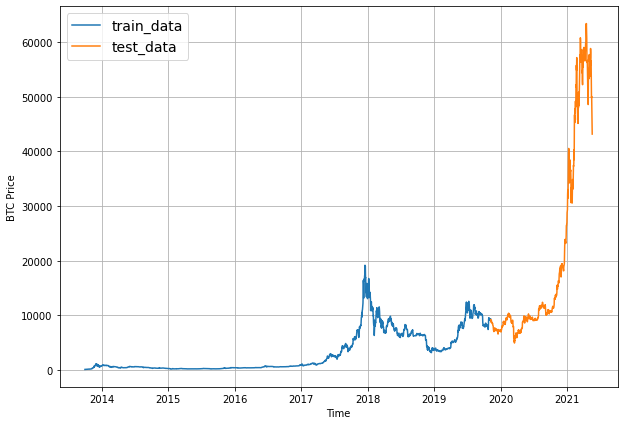

In [47]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="train_data")
plot_time_series(timesteps=X_test, values=y_test, label="test_data")

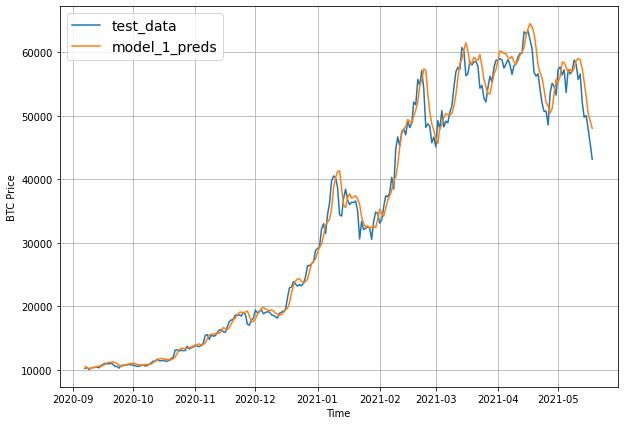

In [48]:
offset = 300
plt.figure(figsize=(10, 7))

# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, label="model_1_preds")

## TODO: Model X: Larger window + horizon

TK - What happens if we make a larger window & horizon?

* TK - Window & horizon values are values you can tune...

In [49]:
HORIZON = 7 # predict a week at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [50]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2724, 2724)

In [51]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2179, 545, 2179, 545)

In [52]:
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=10,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/10
69/69 [==============================] - 1s 4ms/step - loss: 1788.9452 - val_loss: 2050.5278
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
Epoch 2/10
69/69 [==============================] - 0s 2ms/step - loss: 401.6631 - val_loss: 1756.7352
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
Epoch 3/10
69/69 [==============================] - 0s 2ms/step - loss: 336.9275 - val_loss: 1594.0482
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
Epoch 4/10
69/69 [==============================] - 0s 2ms/step - loss: 294.6196 - val_loss: 1695.4669
Epoch 5/10
69/69 [==============================] - 0s 2ms/step - loss: 323.8751 - val_loss: 1792.1202
Epoch 6/10
69/69 [==============================] - 0s 2ms/step - loss: 283.3140 - val_loss: 1455.8199
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
Epoch 7/10
69/69 [==============================] - 0s 2ms/step - loss: 263.1933 - va

In [53]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 982us/step - loss: 1498.2631


1498.2630615234375

In [54]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1386.2922


1386.292236328125

In [55]:
# Get forecast predictions
model_2_preds = make_forecast(model_2,
                              input_data=test_windows)

In [56]:
# Each prediction is a window of 7 steps 
model_2_preds.shape, test_labels.shape

(TensorShape([545, 7]), (545, 7))

In [57]:
# Evaluate results for model 2 predictions, these will be metrics across axes (the shapes above)
model_2_results = evaluate_preds(y_true=test_labels,
                                 y_pred=model_2_preds)
model_2_results

{'mae': array([ 573.0776  ,  654.55505 ,  686.5005  ,  750.38293 ,  796.66785 ,
         904.2235  , 1000.20264 ,  929.39746 ,  669.0141  ,  251.09131 ,
         237.92348 ,  237.30734 ,  218.25328 ,  280.6321  ,  171.19943 ,
         181.03816 ,  210.96443 ,  199.13777 ,  231.43338 ,  137.28947 ,
         110.533   ,  137.12576 ,   95.45368 ,  144.05078 ,  194.57156 ,
         281.0325  ,  373.05734 ,  416.1626  ,  418.6494  ,  358.22894 ,
         383.8188  ,  294.79276 ,  243.87953 ,  225.55127 ,  279.11978 ,
         207.75084 ,   95.98619 ,  147.94482 ,  128.31808 ,  192.41756 ,
          69.72587 ,  105.43883 ,   69.79018 ,   70.55448 ,  129.00941 ,
         144.86287 ,  173.90486 ,  229.96672 ,  294.33133 ,  412.16254 ,
         466.8614  ,  515.1449  ,  526.5519  ,  658.11066 ,  520.4223  ,
         422.6213  ,  405.82986 ,  495.282   ,  509.4929  ,  544.64923 ,
         464.4739  ,  580.10516 ,  398.4357  ,  178.28098 ,  136.76492 ,
         256.39664 ,  419.41586 ,  475.62625

Let's adjust the `evaluate_preds()` to work with multiple shapes.

In [58]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  smape = scaled_mape(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    mape = tf.reduce_mean(mape)
    smape = tf.reduce_mean(smape)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "mape": mape.numpy(),
          "smape": smape.numpy()}

In [59]:
model_2_results = evaluate_preds(y_true=test_labels,
                                 y_pred=model_2_preds)
model_2_results

{'mae': 1386.2922, 'mape': 6.1623425, 'mse': 6415591.0, 'smape': 6.130661}

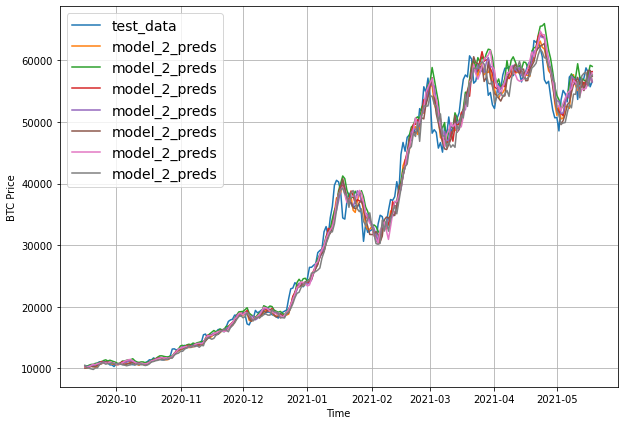

In [60]:
offset = 300
plt.figure(figsize=(10, 7))

# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, label="model_2_preds") # this will buckle (too many shapes)

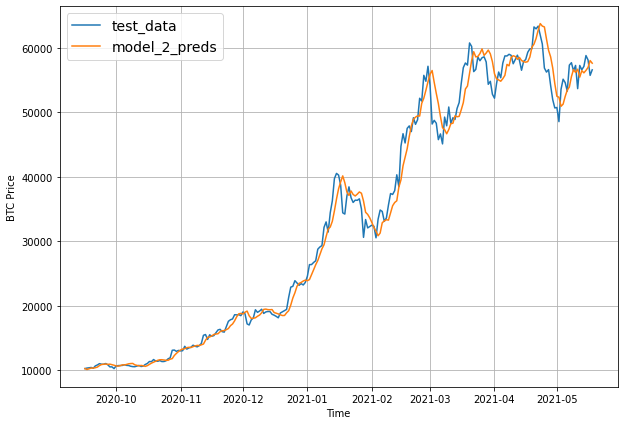

In [61]:
plt.figure(figsize=(10, 7))

# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
# Account for different shapes, but this still predicts an average of 7 days ahead (horizon=7)
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_2_preds, axis=1), start=offset, label="model_2_preds") 

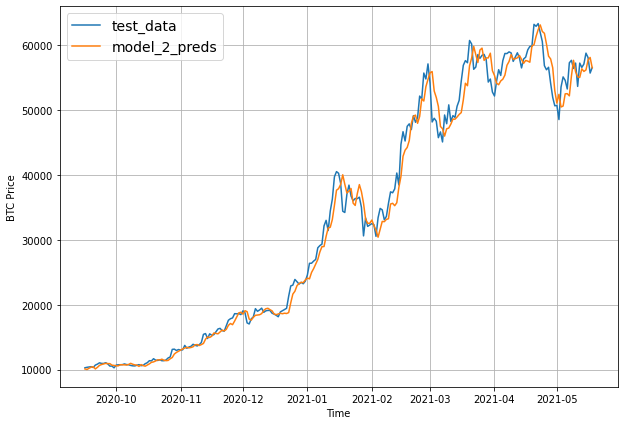

In [62]:
plt.figure(figsize=(10, 7))

# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
# Account for different shapes, but this still predicts an average of 7 days ahead (horizon=7)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds[:, 0], start=offset, label="model_2_preds")

### Model 3: Dense (1 horizon, 30 window)

* -> How does a larger window effect a smaller horizon?
* -> Model 1 looked at predicting horizon=1 with window=10
* -> Model 2: horizon=7, window=30
* -> Model 3: horizon=1, window=30
* -> Compare them all...

In [81]:
HORIZON = 1
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2730, 2730)

In [82]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2184, 546, 2184, 546)

In [91]:
test_labels[-1], y_test[-1]

(array([43144.47129086]), 43144.471290860296)

In [83]:
# Build model
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            epochs=10,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/10
69/69 [==============================] - 1s 4ms/step - loss: 1677.1416 - val_loss: 1539.7159
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
Epoch 2/10
69/69 [==============================] - 0s 2ms/step - loss: 292.0321 - val_loss: 1380.0460
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
Epoch 3/10
69/69 [==============================] - 0s 2ms/step - loss: 251.1237 - val_loss: 1065.5167
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
Epoch 4/10
69/69 [==============================] - 0s 2ms/step - loss: 187.2203 - val_loss: 1640.3303
Epoch 5/10
69/69 [==============================] - 0s 2ms/step - loss: 202.4061 - val_loss: 994.4131
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
Epoch 6/10
69/69 [==============================] - 0s 2ms/step - loss: 167.5045 - val_loss: 827.2507
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
Epoch 7/10
69

In [84]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 748.5568


748.5567626953125

In [85]:
model_3_preds = make_forecast(model_3,
                              input_data=test_windows)

In [86]:
len(model_3_preds)

546

In [95]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 748.55676, 'mape': 3.2615733, 'mse': 1893270.5, 'smape': 3.2330148}

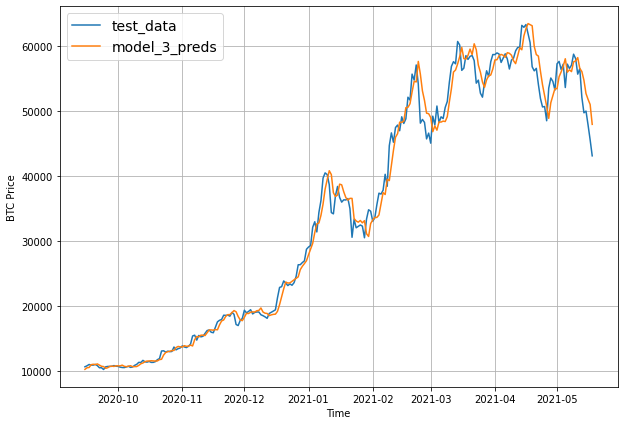

In [94]:
plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

In [96]:
naive_results, model_1_results, model_2_results, model_3_results

({'mae': 567.9802, 'mape': 2.516525, 'mse': 1147547.0, 'smape': 2.5180573},
 {'mae': 717.57965, 'mape': 3.3286731, 'mse': 1756533.4, 'smape': 3.2727804},
 {'mae': 1386.2922, 'mape': 6.1623425, 'mse': 6415591.0, 'smape': 6.130661},
 {'mae': 748.55676, 'mape': 3.2615733, 'mse': 1893270.5, 'smape': 3.2330148})

## TODO: Model X Conv1D

In [192]:
HORIZON = 1
WINDOW_SIZE = 7

In [193]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2779, 2779)

In [194]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2223, 556, 2223, 556)

In [195]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant([1, 2, 3])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))
x.shape, expand_dims_layer(x).shape, expand_dims_layer(x)

(TensorShape([3]),
 TensorShape([3, 1]),
 <tf.Tensor: shape=(3, 1), dtype=int32, numpy=
 array([[1],
        [2],
        [3]], dtype=int32)>)

In [196]:
# Create model
model_4 = tf.keras.Sequential([
  # Without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=3, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels, 
            epochs=10,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/10
70/70 [==============================] - 1s 4ms/step - loss: 1762.3437 - val_loss: 1141.6467
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 2/10
70/70 [==============================] - 0s 2ms/step - loss: 164.2196 - val_loss: 1014.2195
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 3/10
70/70 [==============================] - 0s 2ms/step - loss: 168.6736 - val_loss: 1094.0419
Epoch 4/10
70/70 [==============================] - 0s 2ms/step - loss: 162.4073 - val_loss: 854.2083
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 5/10
70/70 [==============================] - 0s 2ms/step - loss: 144.7439 - val_loss: 909.7705
Epoch 6/10
70/70 [==============================] - 0s 2ms/step - loss: 153.8093 - val_loss: 804.6845
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 7/10
70/70 [==============================] - 0s 2ms/step - loss: 138.8598 - val_loss: 722.7664
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 8/10
70/70 [==============================] - 0s 2ms/step - loss: 133.1034 - val_loss: 816.3023
Epoch 9/10
70/70 [==============================] - 0s 2ms/step - loss: 137.7206 - val_loss: 676.4740
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 10/10
70/70 [==============================] - 0s 2ms/step - loss: 120.6654 - val_loss: 751.0491


In [197]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_36 (Lambda)           (None, 1, 7)              0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1, 128)            2816      
_________________________________________________________________
dense_37 (Dense)             (None, 1, 1)              129       
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [198]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 676.4740


676.4739990234375

In [199]:
# Make predictions
model_4_preds = make_forecast(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9035.316, 8882.988, 8969.594, 8824.   , 8778.451, 8793.549,
       8696.408, 8580.42 , 8533.631, 8515.762], dtype=float32)>

In [200]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 676.474, 'mape': 2.9919226, 'mse': 1529504.5, 'smape': 2.9915662}

In [201]:
model_4_results

{'mae': 676.474, 'mape': 2.9919226, 'mse': 1529504.5, 'smape': 2.9915662}

## TODO: Model X RNN (LSTM)

In [164]:
len(train_windows), len(train_labels)

(2223, 2223)

In [180]:
# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
print(x.shape)
x = layers.Conv1D(128, kernel_size=3, padding="causal", activation="relu")(x)
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x) # this layer will error if the inputs are not the right shape
x = layers.Bidirectional(layers.LSTM(32))(x)
print(x.shape)
# x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(HORIZON)(x)
output = tf.keras.layers.Lambda(lambda x: x * 100)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

(None, 1, 7)
(None, 64)


In [181]:
model_5.summary()

Model: "model_5_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 7)]               0         
_________________________________________________________________
lambda_33 (Lambda)           (None, 1, 7)              0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 1, 128)            2816      
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 1, 64)             41216     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 64)                24832     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 65        
_________________________________________________________________
lambda_34 (Lambda)           (None, 1)                

In [189]:
# Compile model
model_5.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(0.001))

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows,
            train_labels,
            epochs=20,
            validation_data=(test_windows, test_labels))
            # callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 22047534.0845 - val_loss: 671053248.0000
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 18203289.1268 - val_loss: 653609664.0000
Epoch 3/20
70/70 [==============================] - 1s 7ms/step - loss: 16248997.6620 - val_loss: 636617280.0000
Epoch 4/20
70/70 [==============================] - 0s 6ms/step - loss: 16513379.3803 - val_loss: 624343168.0000
Epoch 5/20
70/70 [==============================] - 0s 6ms/step - loss: 14182984.0070 - val_loss: 615274880.0000
Epoch 6/20
70/70 [==============================] - 0s 6ms/step - loss: 14611077.7324 - val_loss: 608344832.0000
Epoch 7/20
70/70 [==============================] - 0s 6ms/step - loss: 15184534.2817 - val_loss: 603940672.0000
Epoch 8/20
70/70 [==============================] - 0s 6ms/step - loss: 14428074.7746 - val_loss: 600884608.0000
Epoch 9/20
70/70 [==============================] - 0s 6ms/step - loss: 13696118.9014 - val_los

In [190]:
model_5.predict(test_windows)

array([[3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150.294],
       [3150

## TODO: Make TensorFlow windows

## TODO: Make future forecasts...

* TODO
  * Make forecasting better (how can I forecast on an arbitrary amount of steps)
  * Create evaluation method for larger windows/horizons
  * Build more modelling experiments
  * Create multivariate time series
  * Create TensorFlow windowing function

* Forecasts can't be compared to anything... because they're a forecast... derp

In [ ]:
WINDOW_SIZE

10

In [ ]:
# TODO: Create make forecast function with:
# Can forecast on any model
# Can forecast on any time series (gets formatted to be same as the model's requirements)

In [ ]:
# Make forecast with one model... 
model_3_forecast = model_3.predict(tf.expand_dims(y_test[-model_3.input_shape[-1]:], axis=0))
model_3_forecast

array([[51037.02]], dtype=float32)

In [ ]:
# TODO: Update this to work with future data...
def make_future_forecast(model, input_data):
  """
  Uses model to make forecasts on input_data.
  """
  forecast = model.predict(tf.expand_dims(input_data[-model.input_shape[-1]:], axis=0)) # make future predictions on last timestep(s) of input_data
  return tf.squeeze(forecast).numpy()

In [ ]:
model_2_forecast = make_forecast(model_2, y_test)
model_2_forecast

array([53904.688, 43581.746, 53670.637, 51078.867, 45989.836, 47447.473,
       44555.715, 46859.6  , 54127.32 , 54640.65 , 52999.043, 52226.145,
       46463.242, 45323.86 ], dtype=float32)

In [ ]:
model_3_forecast = make_forecast(model_3, y_test)
model_3_forecast

51037.02

### TODO: Plot forecasts

* Need: 
  * horizon # of dates in future
  * forecast

In [ ]:
# Last timestep of timesteps (currently in np.datetime64 format)
X_test[-1]

numpy.datetime64('2021-05-18T00:00:00.000000000')

In [ ]:
def get_future_dates(start_date, horizon=1, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  horizon: number of day to add onto start date for range (int)
  offset: if offset=1 (default), original date is not included, if offset=0, original date is included
  """
  return np.arange(start_date + np.timedelta64(offset, "D"), start_date + np.timedelta64(horizon+1, "D"), dtype="datetime64[D]")

In [ ]:
next_time_steps = get_future_dates(start_date=X_test[-1], horizon=HORIZON)

In [ ]:
# Example of getting next two weeks
next_two_weeks = get_future_dates(start_date=X_test[-1], horizon=14)
next_two_weeks

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [ ]:
model_2_forecast = np.insert(model_2_forecast, 0, y_test[-1]) 
future_dates = np.insert(next_two_weeks, 0, X_test[-1])

In [ ]:
model_2_forecast, future_dates

(array([43144.473, 53904.688, 43581.746, 53670.637, 51078.867, 45989.836,
        47447.473, 44555.715, 46859.6  , 54127.32 , 54640.65 , 52999.043,
        52226.145, 46463.242, 45323.86 ], dtype=float32),
 array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'))

TODO: Fix the below graph to have model_2_preds... continued into model 2 forecast, want to have the windowed forecast plottable & then predictions being able to be made multiple steps into the future

In [ ]:
tf.keras.metrics.mean_absolute_error(y_test[WINDOW_SIZE:-(len(y_test) % HORIZON)-1], # account for window sizes/cutoff
                                     tf.reduce_mean(model_2_preds, axis=1))

<tf.Tensor: shape=(), dtype=float32, numpy=1481.0415>

In [ ]:
model_2_results

{'mae': 2529.3965, 'mape': 9.727565, 'mse': 16825896.0, 'smape': 10.112202}

In [ ]:
y_test[140:140+14], test_labels[0]

(array([6721.49539238, 6682.7800492 , 6229.48834283, 5922.48983509,
        6483.73944553, 6446.42134684, 6537.3364615 , 6850.55871169,
        6776.37009357, 6855.93326446, 6805.3622869 , 7278.24396977,
        7175.66747656, 7367.29339845]),
 array([6721.49539238, 6682.7800492 , 6229.48834283, 5922.48983509,
        6483.73944553, 6446.42134684, 6537.3364615 , 6850.55871169,
        6776.37009357, 6855.93326446, 6805.3622869 , 7278.24396977,
        7175.66747656, 7367.29339845]))

In [ ]:
tf.reduce_mean(model_2_preds[-100:], axis=1)

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([36701.473, 36144.57 , 35764.348, 34901.656, 34843.71 , 35094.81 ,
       35132.727, 34703.82 , 34822.19 , 34917.02 , 35235.418, 35918.348,
       36537.855, 36705.363, 37077.176, 38421.293, 39489.344, 40080.098,
       40876.883, 42075.066, 43110.34 , 44393.844, 45216.777, 45956.57 ,
       46855.19 , 48068.395, 49270.723, 50073.617, 51104.812, 51841.305,
       51963.098, 52384.965, 52220.   , 51455.895, 51411.168, 51489.188,
       51131.52 , 50980.19 , 50987.875, 51007.54 , 51163.258, 51886.066,
       52521.082, 52356.008, 53245.973, 54041.48 , 55264.96 , 55964.742,
       56759.926, 57594.387, 58877.68 , 59014.035, 59824.086, 59583.305,
       59824.34 , 60218.43 , 59945.965, 59501.598, 58837.625, 58398.35 ,
       57354.477, 57350.035, 57393.535, 56191.32 , 56402.09 , 56915.77 ,
       56231.77 , 56628.395, 56597.395, 56858.844, 57405.73 , 58069.418,
       57892.56 , 57875.32 , 57569.188, 58106.938, 58683.445, 59460.043,
   

In [ ]:
100-len(y_test) % HORIZON - 1

87

In [ ]:
100+((len(y_test) % HORIZON) - 1)

111

In [ ]:
X_test[-111]

numpy.datetime64('2021-01-28T00:00:00.000000000')

In [ ]:
# Does indexing on this account for the lagging window???
(100+(len(y_test) % HORIZON) - 1)

111

[]

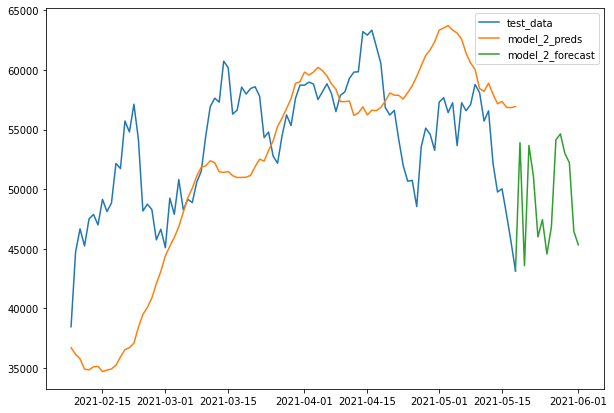

In [ ]:
## TODO: Note the non-adjusted plot here...
# Plot forecast
plt.figure(figsize=(10, 7))
plt.plot(X_test[-100:], y_test[-100:], label="test_data")
# plt.plot(X_train, y_train)
plt.plot(X_test[-100:], tf.reduce_mean(model_2_preds[-100:], axis=1), label="model_2_preds")
plt.plot(future_dates, model_2_forecast.ravel(), label="model_2_forecast")
plt.legend()
plt.plot()

[]

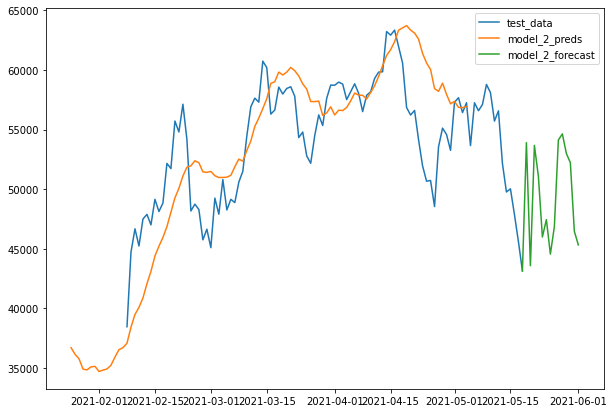

In [ ]:
## TODO: Note the adjusted plot here...
# Plot forecast
plt.figure(figsize=(10, 7))
plt.plot(X_test[-100:], y_test[-100:], label="test_data")
# plt.plot(X_train, y_train)
plt.plot(X_test[-(100+HORIZON):-HORIZON], tf.reduce_mean(model_2_preds[-100:], axis=1), label="model_2_preds")
plt.plot(future_dates, model_2_forecast.ravel(), label="model_2_forecast")
plt.legend()
plt.plot()

# TODO: Make a multivariate time series 

Bitcoin price + halving events...

-> https://www.investopedia.com/bitcoin-halving-4843769

> Vigg_1991: For me … I use sensor data for predictions and forecasting … the toughest part of a time series has been .. when doing multivariate time series … some inputs may have larger scale compared to the target .. therefore do we de-trend all the data to keep them consistent or do we keep them them the way they are … because sometimes they lose the correlation between them once they are retreaded for prediction. How would you handle that ? Or is that important for deep learning predictions?

* inputs: larger scale compared to target
* detrend all the data to keep them consistent? Or keep the same way?
* sometimes they lose the correlation between them once they are de-trended 

## TODO: Make TensorFlow tf.data Windowed Dataset

In [ ]:
# TODO: Use entire time series to predict next step, compare to actual data 
# (e.g. revisit the prices in 1 week & see how the model goes)
# Start date: 18 May 2021
# End date: 25 May 2021 (revisit the updated prices here & see how wrong the model is...)

## TODO: Uncertainty estimates

### TODO: Model X: (model with Dropout to make MC Dropout model)...

# TODO: Why forecasting is BS (turkey problem)

TK - inject a turkey problem piece of data into the model & see how it effects (e.g. 1 data point that's 50x of outlier)

* See this video: https://youtu.be/hRwimmE2wEk
* Open system: beware (like fortune telling), see Mark Saroufim's tweet - https://twitter.com/marksaroufim/status/1366871736604532739?s=20
* Closed system: try it out

# TODO: Exercises

## TODO: Extra-curriculum